In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols # linear ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import statsmodels.formula.api as smf

/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##### Data loading

In [ ]:
maxwalk = pd.read_csv("maxwalk.csv")
maxwalk.shape

(1331, 11)

In [3]:
maxwalk

,mergeid,age,bmi,female,educational_level,OA_conserv,Hypertension,Diabetes,maxgrip,walking,disease_category
0,AT-078466-02,77.0,26.562500,1.0,1.0,0.0,0.0,0.0,23.0,2.495,No disease
1,AT-111399-02,80.0,20.395421,1.0,1.0,0.0,0.0,0.0,22.0,2.265,No disease
2,AT-567061-01,77.0,29.757585,0.0,1.0,0.0,0.0,0.0,39.0,2.390,No disease
3,AT-934728-02,76.0,20.438166,1.0,1.0,0.0,1.0,0.0,23.0,4.985,Only HT
4,AT-971813-02,77.0,29.060607,0.0,1.0,0.0,0.0,0.0,41.0,4.095,No disease
...,...,...,...,...,...,...,...,...,...,...,...
1326,SE-939741-02,77.0,28.066424,0.0,0.0,0.0,1.0,0.0,39.0,4.360,Only HT
1327,SE-965987-02,76.0,31.644286,1.0,0.0,0.0,1.0,0.0,33.0,2.905,Only HT
1328,SE-975106-01,80.0,32.596372,1.0,0.0,0.0,1.0,1.0,26.0,3.140,HT and Diab
1329,SE-988222-01,80.0,24.464602,1.0,0.0,0.0,0.0,0.0,27.0,2.330,No disease


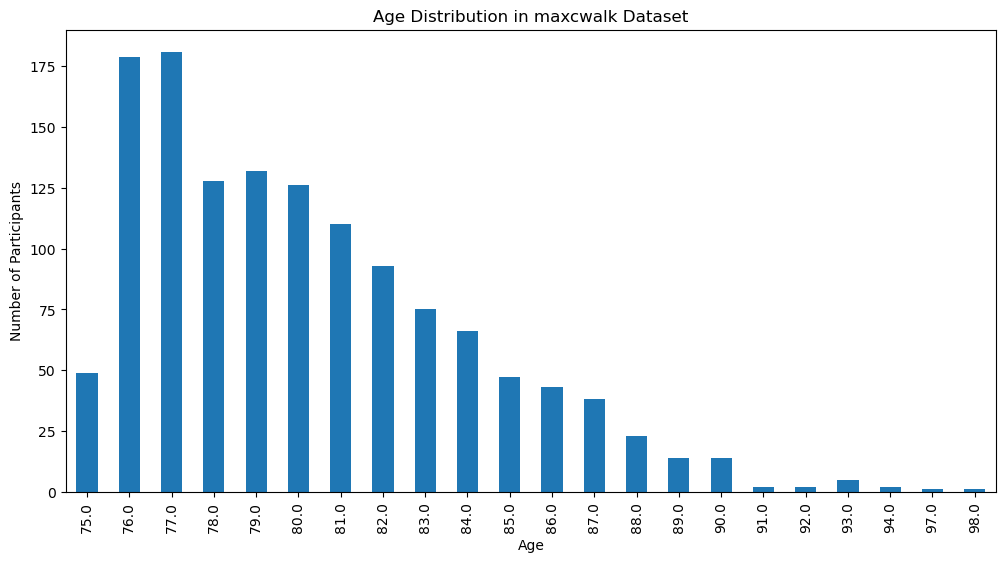

In [4]:
age_counts = maxwalk['age'].value_counts().sort_index()
plt.figure(figsize=(12,6))
age_counts.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Number of Participants')
plt.title('Age Distribution in maxcwalk Dataset')
plt.show()

## statistical

##### Statistics on df_features

- **0**: No disease  
- **1**:  
  - Diabetes only  
  - Hypertension only  
  - OA only  
- **2**:  
  - Diabetes + Hypertension  
  - Diabetes + OA  
  - Hypertension + OA  
- **3**: Diabetes + Hypertension + OA 


In [5]:
maxwalk['disease_category'] = 'No disease'  # Default group
maxwalk.loc[(maxwalk['OA_conserv'] == 1) & (maxwalk['Hypertension'] == 0) & (maxwalk['Diabetes'] == 0), 'disease_category'] = 'Only OA'
maxwalk.loc[(maxwalk['OA_conserv'] == 0) & (maxwalk['Hypertension'] == 1) & (maxwalk['Diabetes'] == 0), 'disease_category'] = 'Only HT'
maxwalk.loc[(maxwalk['OA_conserv'] == 0) & (maxwalk['Hypertension'] == 0) & (maxwalk['Diabetes'] == 1), 'disease_category'] = 'Only Diabetes'
maxwalk.loc[(maxwalk['OA_conserv'] == 1) & (maxwalk['Hypertension'] == 1) & (maxwalk['Diabetes'] == 0), 'disease_category'] = 'OA and HT'
maxwalk.loc[(maxwalk['OA_conserv'] == 1) & (maxwalk['Hypertension'] == 0) & (maxwalk['Diabetes'] == 1), 'disease_category'] = 'OA and Diab'
maxwalk.loc[(maxwalk['OA_conserv'] == 0) & (maxwalk['Hypertension'] == 1) & (maxwalk['Diabetes'] == 1), 'disease_category'] = 'HT and Diab'
maxwalk.loc[(maxwalk['OA_conserv'] == 1) & (maxwalk['Hypertension'] == 1) & (maxwalk['Diabetes'] == 1), 'disease_category'] = 'All three diseases'


### Maxgrip

#### No confounding

##### Step1: One-Way ANOVA

Checks if any group differs

In [6]:
groups = maxwalk['disease_category'].unique()
grip_samples = [maxwalk[maxwalk['disease_category'] == group]['maxgrip'].dropna() for group in groups]

# Run ANOVA
anova_grip = f_oneway(*grip_samples)
print("ANOVA for Grip Strength")
print(f"F-statistic: {anova_grip.statistic:.3f}, p-value: {anova_grip.pvalue:.5f}")


ANOVA for Grip Strength
F-statistic: 5.582, p-value: 0.00000


##### Step2: Tukey HSD Post-hoc Comparison

Identifies which groups differ

In [7]:
df_grip = maxwalk[['maxgrip', 'disease_category']].dropna()

# Run Tukey HSD
tukey_grip = pairwise_tukeyhsd(endog=df_grip['maxgrip'],
                               groups=df_grip['disease_category'],
                               alpha=0.05)
print("Turkey Maxgrip in age 75 or above 75")
print(tukey_grip.summary())


Turkey Maxgrip in age 75 or above 75
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1           group2    meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------
All three diseases   HT and Diab   0.9276 0.9997 -4.8619 6.7171  False
All three diseases    No disease   4.3115 0.1399 -0.6313 9.2543  False
All three diseases   OA and Diab    1.406 0.9992 -6.0895 8.9014  False
All three diseases     OA and HT   1.7661 0.9774 -3.7107 7.2429  False
All three diseases Only Diabetes   1.9584 0.9697 -3.8071  7.724  False
All three diseases       Only HT    2.552 0.7798 -2.4456 7.5495  False
All three diseases       Only OA  -0.6599    1.0 -6.0732 4.7534  False
       HT and Diab    No disease   3.3839 0.0664 -0.1151 6.8829  False
       HT and Diab   OA and Diab   0.4783    1.0 -6.1544 7.1111  False
       HT and Diab     OA and HT   0.8385 0.9988 -3.3814 5.0583  False
       HT and Diab Only Diabetes   1.030

##### Number of samples in each group

In [8]:
group_counts = maxwalk[maxwalk['maxgrip'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
All three diseases     35
HT and Diab            75
No disease            507
OA and Diab            24
OA and HT             112
Only Diabetes          77
Only HT               377
Only OA               124
dtype: int64


##### Step3: Code to Compute Cohen's d and 95% CI

In [9]:
comparisons = [
    ("No disease", "Only OA"),
    ("No disease", "Only HT"),
    ("No disease", "Only Diabetes"),
    ("No disease", "HT and Diab"),
    ("No disease", "OA and Diab"),
    ("No disease", "OA and HT"),
    ("No disease", "All three diseases")
]

results = []

for g1, g2 in comparisons:
   
    group1 = maxwalk[(maxwalk['disease_category'] == g1)]['maxgrip'].dropna()
    group2 = maxwalk[(maxwalk['disease_category'] == g2)]['maxgrip'].dropna()

    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)


    pooled_sd = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

    cohen_d = (mean1 - mean2) / pooled_sd

    diff = mean1 - mean2
    se_diff = np.sqrt(std1**2 / n1 + std2**2 / n2)
    ci_low, ci_high = diff - 1.96 * se_diff, diff + 1.96 * se_diff

    results.append({
        'Comparison': f"{g1} vs {g2}",
        'Mean1': round(mean1, 2),
        'Mean2': round(mean2, 2),
        'Cohen_d': round(cohen_d, 3),
        '95% CI Lower': round(ci_low, 3),
        '95% CI Upper': round(ci_high, 3),
        'n1': n1,
        'n2': n2
    })

effect_df = pd.DataFrame(results)
effect_df


,Comparison,Mean1,Mean2,Cohen_d,95% CI Lower,95% CI Upper,n1,n2
0,No disease vs Only OA,29.2,24.23,0.534,3.168,6.775,507,124
1,No disease vs Only HT,29.2,27.44,0.188,0.511,3.009,507,377
2,No disease vs Only Diabetes,29.2,26.84,0.254,0.248,4.458,507,77
3,No disease vs HT and Diab,29.2,25.81,0.368,1.386,5.382,507,75
4,No disease vs OA and Diab,29.2,26.29,0.314,-0.032,5.843,507,24
5,No disease vs OA and HT,29.2,26.65,0.265,0.389,4.702,507,112
6,No disease vs All three diseases,29.2,24.89,0.463,1.304,7.319,507,35


#### With confounding: age, BMI, female, educational_level:

Run OLS model (adjusted for age, bmi, female)

In [10]:
maxwalk['disease_category'] = pd.Categorical(
    maxwalk['disease_category'],
    categories=[
        'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
        'HT and Diab', 'OA and Diab', 'OA and HT', 'All three diseases'
    ],
    ordered=False
)


model = smf.ols('maxgrip ~ C(disease_category) + age + bmi + female + educational_level', data=maxwalk).fit()


results_df = pd.DataFrame({
    'Disease group': model.params.index,
    'Coefficient (Adj. Mean Diff)': model.params.values,
    '95% CI Lower': model.conf_int().iloc[:, 0],
    '95% CI Upper': model.conf_int().iloc[:, 1],
    'p-value': model.pvalues.values
})


results_df = results_df[results_df['Disease group'].str.contains('C\(disease_category\)')].copy()


results_df['Disease group'] = results_df['Disease group'].str.replace(r'C\(disease_category\)\[T\.', '', regex=True).str.rstrip(']')


results_df['Coefficient (Adj. Mean Diff)'] = results_df['Coefficient (Adj. Mean Diff)'].round(3)
results_df['95% CI Lower'] = results_df['95% CI Lower'].round(3)
results_df['95% CI Upper'] = results_df['95% CI Upper'].round(3)
results_df['p-value'] = results_df['p-value'].round(4)

results_df['Significant'] = results_df['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

print("OLS results for maxgrip in age 75 or above 75 (No disease as reference):")
results_df.reset_index(drop=True)



OLS results for maxgrip in age 75 or above 75 (No disease as reference):


,Disease group,Coefficient (Adj. Mean Diff),95% CI Lower,95% CI Upper,p-value,Significant
0,Only OA,-3.061,-4.405,-1.717,0.0000,Yes
1,Only HT,-0.399,-1.312,0.514,0.3917,No
2,Only Diabetes,-2.137,-3.774,-0.501,0.0105,Yes
3,HT and Diab,-1.282,-2.947,0.382,0.1309,No
4,OA and Diab,-4.091,-6.883,-1.298,0.0041,Yes
5,OA and HT,-0.954,-2.360,0.452,0.1832,No
6,All three diseases,-2.562,-4.922,-0.203,0.0333,Yes


##### Interaction Effects: Does OA Get Worse With Comorbidities?

In [11]:
model = smf.ols('maxgrip ~ C(disease_category) + age + bmi + female + educational_level + C(OA_conserv)*C(Diabetes) + C(OA_conserv)*C(Hypertension)', 
                data=maxwalk).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                maxgrip   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     113.2
Date:                Tue, 22 Jul 2025   Prob (F-statistic):          1.33e-181
Time:                        10:11:42   Log-Likelihood:                -4431.9
No. Observations:                1331   AIC:                             8888.
Df Residuals:                    1319   BIC:                             8950.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

##### Logistic Regression: Predicting "High Risk" Patients

In [12]:
maxwalk['low_grip'] = (maxwalk['maxgrip'] < maxwalk['maxgrip'].quantile(0.25)).astype(int)

X = maxwalk[['age', 'bmi', 'female', 'educational_level','OA_conserv', 'Diabetes', 'Hypertension']]
y = maxwalk['low_grip']

logit_model = sm.Logit(y, sm.add_constant(X)).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.431092
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               low_grip   No. Observations:                 1331
Model:                          Logit   Df Residuals:                     1323
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                  0.2337
Time:                        10:11:42   Log-Likelihood:                -573.78
converged:                       True   LL-Null:                       -748.74
Covariance Type:            nonrobust   LLR p-value:                 1.282e-71
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -12.8417      1.637     -7.846      0.000     -16.049      -9.634
age     

### Walking

#### No confounding

##### Step1: One-Way ANOVA

Checks if any group differs

In [13]:
# ANOVA for walking speed
walking_samples = [maxwalk[maxwalk['disease_category'] == group]['walking'].dropna() for group in groups]

anova_walking = f_oneway(*walking_samples)
print("\nANOVA for walking speed")
print(f"F-statistic: {anova_walking.statistic:.3f}, p-value: {anova_walking.pvalue:.5f}")



ANOVA for walking speed
F-statistic: 1.550, p-value: 0.14652


##### Step2: Tukey HSD Post-hoc Comparison

Identifies which groups differ

In [14]:
# Tukey HSD for Walking speed
df_walking = maxwalk[['walking', 'disease_category']].dropna()

tukey_walking = pairwise_tukeyhsd(endog=df_walking['walking'],
                                groups=df_walking['disease_category'],
                                alpha=0.05)
print("Turkey Walking Speed in age 75 or above 75")
print(tukey_walking.summary())


Turkey Walking Speed in age 75 or above 75
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1           group2    meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------
All three diseases   HT and Diab   0.4117 0.9996 -2.0002 2.8236  False
All three diseases    No disease  -0.5084 0.9954 -2.5676 1.5507  False
All three diseases   OA and Diab   0.4592 0.9998 -2.6634 3.5818  False
All three diseases     OA and HT  -0.1049    1.0 -2.3865 2.1768  False
All three diseases Only Diabetes   0.5297 0.9977 -1.8722 2.9316  False
All three diseases       Only HT  -0.5019  0.996 -2.5839   1.58  False
All three diseases       Only OA   0.0402    1.0  -2.215 2.2954  False
       HT and Diab    No disease  -0.9201 0.5398 -2.3778 0.5375  False
       HT and Diab   OA and Diab   0.0475    1.0 -2.7157 2.8107  False
       HT and Diab     OA and HT  -0.5165 0.9868 -2.2745 1.2414  False
       HT and Diab Only Diabetes  

##### Number of samples in each group

In [15]:
group_counts = maxwalk[maxwalk['walking'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
No disease            507
Only OA               124
Only HT               377
Only Diabetes          77
HT and Diab            75
OA and Diab            24
OA and HT             112
All three diseases     35
dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_65570/3308135134.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = maxwalk[maxwalk['walking'].notna()].groupby('disease_category').size()


##### Step3: Compute Cohen's d and 95% CI

In [16]:
comparisons = [
    ("No disease", "Only OA"),
    ("No disease", "Only HT"),
    ("No disease", "Only Diabetes"),
    ("No disease", "HT and Diab"),
    ("No disease", "OA and Diab"),
    ("No disease", "OA and HT"),
    ("No disease", "All three diseases")
]

results = []

for g1, g2 in comparisons:
    
    group1 = maxwalk[(maxwalk['disease_category'] == g1)]['walking'].dropna()
    group2 = maxwalk[(maxwalk['disease_category'] == g2)]['walking'].dropna()


    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)

    pooled_sd = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))


    cohen_d = (mean1 - mean2) / pooled_sd

   
    diff = mean1 - mean2
    se_diff = np.sqrt(std1**2 / n1 + std2**2 / n2)
    ci_low, ci_high = diff - 1.96 * se_diff, diff + 1.96 * se_diff

    results.append({
        'Comparison': f"{g1} vs {g2}",
        'Mean1': round(mean1, 2),
        'Mean2': round(mean2, 2),
        'Cohen_d': round(cohen_d, 3),
        '95% CI Lower': round(ci_low, 3),
        '95% CI Upper': round(ci_high, 3),
        'n1': n1,
        'n2': n2
    })

effect_df = pd.DataFrame(results)
effect_df


,Comparison,Mean1,Mean2,Cohen_d,95% CI Lower,95% CI Upper,n1,n2
0,No disease vs Only OA,4.79,5.34,-0.145,-1.295,0.198,507,124
1,No disease vs Only HT,4.79,4.80,-0.002,-0.495,0.482,507,377
2,No disease vs Only Diabetes,4.79,5.83,-0.258,-2.291,0.215,507,77
3,No disease vs HT and Diab,4.79,5.71,-0.237,-2.025,0.185,507,75
4,No disease vs OA and Diab,4.79,5.76,-0.258,-2.392,0.457,507,24
5,No disease vs OA and HT,4.79,5.20,-0.106,-1.202,0.395,507,112
6,No disease vs All three diseases,4.79,5.30,-0.137,-1.537,0.521,507,35


#### With confounding: age, BMI, female, educational_level:

Run OLS model (adjusted for age, bmi, female)

In [17]:
maxwalk['disease_category'] = pd.Categorical(
    maxwalk['disease_category'],
    categories=[
        'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
        'HT and Diab', 'OA and Diab', 'OA and HT', 'All three diseases'
    ],
    ordered=False
)


model = smf.ols('walking ~ C(disease_category) + age + bmi + female + educational_level', data=maxwalk).fit()


results_df = pd.DataFrame({
    'Disease group': model.params.index,
    'Coefficient (Adj. Mean Diff)': model.params.values,
    '95% CI Lower': model.conf_int().iloc[:, 0],
    '95% CI Upper': model.conf_int().iloc[:, 1],
    'p-value': model.pvalues.values
})


results_df = results_df[results_df['Disease group'].str.contains('C\(disease_category\)')].copy()


results_df['Disease group'] = results_df['Disease group'].str.replace(r'C\(disease_category\)\[T\.', '', regex=True).str.rstrip(']')


results_df['Coefficient (Adj. Mean Diff)'] = results_df['Coefficient (Adj. Mean Diff)'].round(3)
results_df['95% CI Lower'] = results_df['95% CI Lower'].round(3)
results_df['95% CI Upper'] = results_df['95% CI Upper'].round(3)
results_df['p-value'] = results_df['p-value'].round(4)
results_df['Significant'] = results_df['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

print("OLS results for walking speed in age 75 or above (No disease as reference):")
results_df.reset_index(drop=True)


OLS results for walking speed in age 75 or above (No disease as reference):


,Disease group,Coefficient (Adj. Mean Diff),95% CI Lower,95% CI Upper,p-value,Significant
0,Only OA,0.308,-0.449,1.065,0.4248,No
1,Only HT,-0.146,-0.661,0.368,0.5768,No
2,Only Diabetes,0.895,-0.027,1.818,0.0570,No
3,HT and Diab,0.608,-0.330,1.546,0.2034,No
4,OA and Diab,0.910,-0.664,2.483,0.2569,No
5,OA and HT,0.103,-0.689,0.895,0.7989,No
6,All three diseases,0.143,-1.187,1.472,0.8330,No


In [18]:
group_counts = maxwalk[maxwalk['walking'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
No disease            507
Only OA               124
Only HT               377
Only Diabetes          77
HT and Diab            75
OA and Diab            24
OA and HT             112
All three diseases     35
dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_65570/3308135134.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = maxwalk[maxwalk['walking'].notna()].groupby('disease_category').size()


##### Interaction Effects: Does OA Get Worse With Comorbidities?

In [19]:
model = smf.ols('walking ~ C(disease_category) + age + bmi + female + educational_level + C(OA_conserv)*C(Diabetes) + C(OA_conserv)*C(Hypertension)', 
                data=maxwalk).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                walking   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.914
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           1.68e-07
Time:                        10:11:42   Log-Likelihood:                -3668.3
No. Observations:                1331   AIC:                             7361.
Df Residuals:                    1319   BIC:                             7423.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

##### Logistic Regression: Predicting "High Risk" Patients

In [20]:
maxwalk['low_grip'] = (maxwalk['walking'] < maxwalk['walking'].quantile(0.25)).astype(int)

X = maxwalk[['age', 'bmi', 'female', 'educational_level','OA_conserv', 'Diabetes', 'Hypertension']]
y = maxwalk['low_grip']

logit_model = sm.Logit(y, sm.add_constant(X)).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.546586
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               low_grip   No. Observations:                 1331
Model:                          Logit   Df Residuals:                     1323
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                 0.02693
Time:                        10:11:42   Log-Likelihood:                -727.51
converged:                       True   LL-Null:                       -747.64
Covariance Type:            nonrobust   LLR p-value:                 1.115e-06
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.3139      1.570      3.385      0.001       2.237       8.391
age     

## Summery table (Table 1 in paper)

In [21]:
groups = [
    'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
    'OA and Diab', 'OA and HT', 'HT and Diab', 'All three diseases'
]

maxwalk = maxwalk[maxwalk['disease_category'].isin(groups)].copy()

summary = {}

for group in groups:
    sub = maxwalk[maxwalk['disease_category'] == group]
    
    n = len(sub)
    percent = 100 * n / len(maxwalk)
    
    age_mean = sub['age'].mean()
    age_sd = sub['age'].std()
    age_min = sub['age'].min()
    age_max = sub['age'].max()

    female_n = sub['female'].sum()
    female_percent = 100 * female_n / n if n > 0 else 0
    
    bmi_mean = sub['bmi'].mean()
    bmi_sd = sub['bmi'].std()
    
    edu_counts = sub['educational_level'].value_counts(dropna=False)
    edu_percents = sub['educational_level'].value_counts(normalize=True, dropna=False) * 100
    
    edu_low = edu_counts.get(0, 0)
    edu_medium = edu_counts.get(1, 0)
    edu_high = edu_counts.get(2, 0)
    edu_other = edu_counts.get(3, 0)
    
    edu_low_pct = edu_percents.get(0, 0)
    edu_medium_pct = edu_percents.get(1, 0)
    edu_high_pct = edu_percents.get(2, 0)
    edu_other_pct = edu_percents.get(3, 0)

    grip_mean = sub['maxgrip'].mean()
    grip_sd = sub['maxgrip'].std()
    
    
    walking_mean = sub['walking'].mean()
    walking_sd = sub['walking'].std()
    
  
    summary[group] = [
        f"{n} ({percent:.2f}%)",
        f"{age_mean:.1f} ± {age_sd:.1f} ({age_min}-{age_max})",  
        f"{female_n} ({female_percent:.1f}%)",
        f"{bmi_mean:.1f} ± {bmi_sd:.1f}",
        f"{edu_low} ({edu_low_pct:.1f}%)",
        f"{edu_medium} ({edu_medium_pct:.1f}%)",
        f"{edu_high} ({edu_high_pct:.1f}%)",
        f"{edu_other} ({edu_other_pct:.1f}%)",
        f"{grip_mean:.1f} ± {grip_sd:.1f}",
        f"{walking_mean:.1f} ± {walking_sd:.1f}"
    ]

variables = [
    "Number of cases",
    "Age; mean (SD) (min-max):",
    "Female; n, (%)",
    "BMI; mean (SD)",
    "Educational Level Low (%)",
    "Educational Level Medium (%)",
    "Educational Level High (%)",
    "Educational Level Other (%)",
    "maxgrip (kg); mean (SD)",
    "walking; mean (SD)"
]

summary_df = pd.DataFrame(summary, index=variables)

summary_df


,No disease,Only OA,Only HT,Only Diabetes,OA and Diab,OA and HT,HT and Diab,All three diseases
Number of cases,507 (38.09%),124 (9.32%),377 (28.32%),77 (5.79%),24 (1.80%),112 (8.41%),75 (5.63%),35 (2.63%)
Age; mean (SD) (min-max):,80.2 ± 3.9 (75.0-97.0),80.6 ± 3.8 (75.0-92.0),80.2 ± 3.9 (75.0-98.0),79.7 ± 3.3 (75.0-88.0),78.8 ± 3.2 (75.0-87.0),80.4 ± 4.0 (75.0-94.0),80.3 ± 3.3 (75.0-87.0),79.6 ± 3.5 (75.0-88.0)
"Female; n, (%)",226.0 (44.6%),74.0 (59.7%),212.0 (56.2%),38.0 (49.4%),10.0 (41.7%),65.0 (58.0%),47.0 (62.7%),22.0 (62.9%)
BMI; mean (SD),25.2 ± 4.4,26.4 ± 6.5,26.1 ± 3.8,26.9 ± 3.8,27.6 ± 5.5,27.3 ± 3.8,27.4 ± 4.1,29.1 ± 4.1
Educational Level Low (%),256 (50.5%),76 (61.3%),203 (53.8%),48 (62.3%),14 (58.3%),60 (53.6%),37 (49.3%),13 (37.1%)
Educational Level Medium (%),142 (28.0%),17 (13.7%),100 (26.5%),13 (16.9%),7 (29.2%),26 (23.2%),19 (25.3%),11 (31.4%)
Educational Level High (%),79 (15.6%),22 (17.7%),53 (14.1%),8 (10.4%),0 (0.0%),17 (15.2%),14 (18.7%),5 (14.3%)
Educational Level Other (%),30 (5.9%),9 (7.3%),21 (5.6%),8 (10.4%),3 (12.5%),9 (8.0%),5 (6.7%),6 (17.1%)
maxgrip (kg); mean (SD),29.2 ± 9.3,24.2 ± 9.1,27.4 ± 9.4,26.8 ± 8.7,26.3 ± 7.1,26.7 ± 10.8,25.8 ± 8.1,24.9 ± 8.7
walking; mean (SD),4.8 ± 3.8,5.3 ± 3.8,4.8 ± 3.6,5.8 ± 5.4,5.8 ± 3.5,5.2 ± 3.9,5.7 ± 4.7,5.3 ± 2.9
